# CNN_3channel_Fit_VGG19_FineTune

Abstract:
- REsize image to fit VGG19
- CNN, small net

Result:
- Kaggle score: 

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl
- https://www.kaggle.com/henokanh/cnn-batchnormalization-0-1646

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import gc

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel_Fit_VGG19_FineTune'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_CNN_3channel_Fit_VGG19_FineTune_20180105_140424


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\input
log_path: D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log
model_path: D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\model
output_path: D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

### Load data

In [6]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [7]:
is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')
y_data = pickle.load(open(is_iceberg_path, mode='rb'))

describe(y_data)

(1604,) 0 1 12936


In [8]:
%%time
#Load orignal data
inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

inc_angle_data = pickle.load(open(inc_angle_data_path, mode='rb'))
inc_angle_test = pickle.load(open(inc_angle_test_path, mode='rb'))

describe(inc_angle_data)
describe(inc_angle_test)

(1604,) 0.0 45.9375 12936
(8424,) 23.0805 50.66178518 67496
Wall time: 3.01 ms


In [9]:
%%time
#Load orignal data
# band1_data_path = os.path.join(input_path, 'band1_data_gray200.p')
# band2_data_path = os.path.join(input_path, 'band2_data_gray200.p')
# band1_test_path = os.path.join(input_path, 'band1_test_gray200.p')
# band2_test_path = os.path.join(input_path, 'band2_test_gray200.p')

band1_data_path = os.path.join(input_path, 'band1_data_gray.p')
band2_data_path = os.path.join(input_path, 'band2_data_gray.p')
band1_test_path = os.path.join(input_path, 'band1_test_gray.p')
band2_test_path = os.path.join(input_path, 'band2_test_gray.p')

band1_data = pickle.load(open(band1_data_path, mode='rb'))
band2_data = pickle.load(open(band2_data_path, mode='rb'))
band1_test = pickle.load(open(band1_test_path, mode='rb'))
band2_test = pickle.load(open(band2_test_path, mode='rb'))

band_avg_data = (band1_data + band2_data)/2
band_avg_test = (band1_test + band2_test)/2


describe(band1_data)
describe(band2_data)
describe(band1_test)
describe(band2_test)

describe(band_avg_data)
describe(band_avg_test)

(1604, 75, 75) 0.0 1.0 128
(1604, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
(1604, 75, 75) 0.0114754206838 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
Wall time: 1.09 s


In [10]:
%%time
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_avg_data[:, :, :, np.newaxis]], axis=-1)
describe(x_data)
del band1_data
del band2_data
del band_avg_data
gc.collect()
x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_avg_test[:, :, :, np.newaxis]], axis=-1)
describe(x_test)
del band1_test
del band2_test
del band_avg_test
gc.collect()

(1604, 75, 75, 3) 0.0 1.0 216540144
(8424, 75, 75, 3) 0.0 1.0 1137240144
Wall time: 840 ms


In [11]:
%%time
x_train, x_val, inc_angle_train, inc_angle_val, y_train, y_val = train_test_split(x_data, inc_angle_data, y_data, test_size=0.15, random_state=31)
print(x_train.shape)
print(x_val.shape)
print(inc_angle_train.shape)
print(inc_angle_val.shape)
print(y_train.shape)
print(y_val.shape)

(1363, 75, 75, 3)
(241, 75, 75, 3)
(1363,)
(241,)
(1363,)
(241,)
Wall time: 63.2 ms


## 2. Build model

In [12]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [13]:
base_model = VGG19(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
model.summary()
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [15]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

In [16]:
# batch_size = 32
# steps_per_epoch = 1 * len(x_train) / batch_size
# hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, shuffle = True),
#                            steps_per_epoch=steps_per_epoch, 
#                            epochs = 10, #1 for ETA, 0 for silent
#                            verbose= 1,
#                            max_queue_size= 16, 
#                            workers= 8,
#                            validation_data=(x_val, y_val))

In [17]:
%%time
hist = model.fit(x_train, y_train, 
                 batch_size = 2, 
                 verbose= 1,
                 epochs = 10, #1 for ETA, 0 for silent
                 validation_data=(x_val, y_val))

Train on 1363 samples, validate on 241 samples
Epoch 1/10
1363/1363 [==============================] - 8s 6ms/step - loss: 0.5729 - acc: 0.6750 - val_loss: 0.5511 - val_acc: 0.6971
Epoch 2/10
1363/1363 [==============================] - 7s 5ms/step - loss: 0.4818 - acc: 0.7542 - val_loss: 0.4523 - val_acc: 0.7552
Epoch 3/10
1363/1363 [==============================] - 7s 5ms/step - loss: 0.4438 - acc: 0.7762 - val_loss: 0.4393 - val_acc: 0.7427
Epoch 4/10
1363/1363 [==============================] - 7s 5ms/step - loss: 0.4127 - acc: 0.7880 - val_loss: 0.4216 - val_acc: 0.7801
Epoch 5/10
1363/1363 [==============================] - 7s 5ms/step - loss: 0.4030 - acc: 0.7880 - val_loss: 0.4209 - val_acc: 0.8133
Epoch 6/10
1363/1363 [==============================] - 7s 5ms/step - loss: 0.3883 - acc: 0.7960 - val_loss: 0.4280 - val_acc: 0.8216
Epoch 7/10
1363/1363 [==============================] - 7s 5ms/step - loss: 0.3829 - acc: 0.8144 - val_loss: 0.4042 - val_acc: 0.8091
Epoch 8/10
1363

In [18]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

241/241 [==============================] - 0s 2ms/step
Final loss: 0.3843, final accuracy: 0.7884


In [19]:
val_prob1 = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.3842636418865904
Val log_loss: 0.3954214886201862


In [20]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_Fit_VGG19_FineTune_20180105_140424_3954


In [21]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


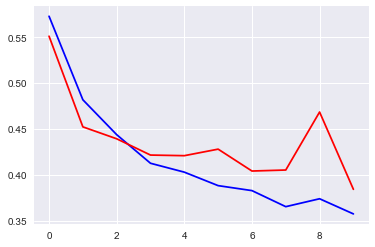

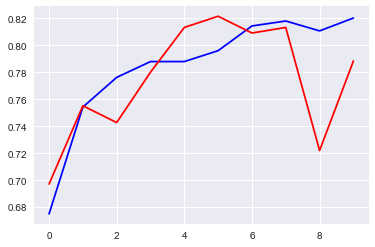

In [22]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [23]:
for layer in model.layers[:11]:
   layer.trainable = False
for layer in model.layers[11:]:
   layer.trainable = True

from keras.optimizers import SGD
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')
model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [24]:
%%time
hist = model.fit(x_train, y_train, 
                 batch_size = 2, 
                 verbose= 1,
                 epochs = 10, #1 for ETA, 0 for silent
                 validation_data=(x_val, y_val))

Train on 1363 samples, validate on 241 samples
Epoch 1/10
1363/1363 [==============================] - 28s 20ms/step - loss: 7.1165 - acc: 0.5348 - val_loss: 7.0224 - val_acc: 0.5643
Epoch 2/10
1363/1363 [==============================] - 27s 20ms/step - loss: 7.6629 - acc: 0.5246 - val_loss: 7.0224 - val_acc: 0.5643
Epoch 3/10
1363/1363 [==============================] - 27s 20ms/step - loss: 7.6629 - acc: 0.5246 - val_loss: 7.0224 - val_acc: 0.5643
Epoch 4/10
1363/1363 [==============================] - 27s 20ms/step - loss: 7.6629 - acc: 0.5246 - val_loss: 7.0224 - val_acc: 0.5643
Epoch 5/10
1363/1363 [==============================] - 27s 19ms/step - loss: 7.6629 - acc: 0.5246 - val_loss: 7.0224 - val_acc: 0.5643
Epoch 6/10
1363/1363 [==============================] - 27s 20ms/step - loss: 7.6629 - acc: 0.5246 - val_loss: 7.0224 - val_acc: 0.5643
Epoch 7/10
1363/1363 [==============================] - 27s 20ms/step - loss: 7.6629 - acc: 0.5246 - val_loss: 7.0224 - val_acc: 0.5643
E

In [25]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

241/241 [==============================] - 0s 1ms/step
Final loss: 7.0224, final accuracy: 0.5643


In [26]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, 'saveModel_test')

In [27]:
# def get_lr(x):
#     lr = round(1e-4 * 0.98 ** x, 6)
#     if lr < 5e-5:
#         lr = 5e-5
#     print(lr, end='  ')
#     return lr

# # annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
# annealer = LearningRateScheduler(get_lr)

# log_dir = os.path.join(log_path, run_name)
# print('log_dir:' + log_dir)
# tensorBoard = TensorBoard(log_dir=log_dir)

In [28]:
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=[0.001, 0.1],
#     channel_shift_range=0.1,
#     horizontal_flip=False,
#     vertical_flip=False)

In [29]:
val_prob1 = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 4.314825551355397
Val log_loss: 1.3341401738744554


In [30]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_Fit_VGG19_FineTune_20180105_140424_13341


In [31]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


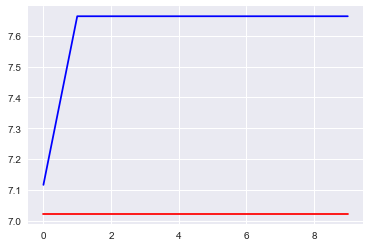

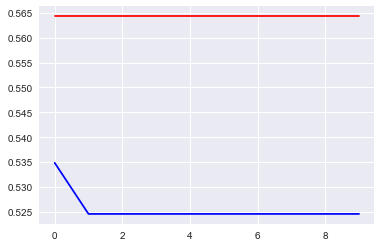

In [32]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [33]:
saveModel(model, run_name_acc)

## 3. Predict

In [34]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output\SC_Iceberg_Classifier_CNN_3channel_Fit_VGG19_FineTune_20180105_140424_13341.csv


In [35]:
test_prob = model.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[ 0.]
 [ 0.]]
(8424, 1)
[[ 0.05]
 [ 0.05]]


In [36]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d        0.05
1  4023181e        0.05
(8424, 2)


In [37]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print(run_name_acc)
print('Done!')

SC_Iceberg_Classifier_CNN_3channel_Fit_VGG19_FineTune_20180105_140424_13341
Done!
